<a href="https://colab.research.google.com/github/gvozdila/kaggle-xray/blob/FastAI/ProgressiveResizingBaseline_resnet152_Adam_Aug2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
#для kaggle 
#!pip install --user ../input/fastaimaster/torch-1.9.0-cp37-cp37m-manylinux1_x86_64.whl
!pip install -U fastai


Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [2]:
import fastcore
import fastai
print(f'fastcore version {fastcore.__version__} installed.')
print(f'fastai version {fastai.__version__} installed.')

fastcore version 1.4.5 installed.
fastai version 2.7.6 installed.


In [ ]:
#Когда будем юзать fastai2.medical.imaging , пока не используется
#!pip install pydicom kornia opencv-python scikit-image

In [3]:
import pandas as pd
%matplotlib inline

In [ ]:
#!pip install --no-cache-dir -I pillow
#еще один костыль.Если  ругается,типа AttributeError: module 'PIL.Image' has no attribute 'Resampling',раскомментировать и выполнить один раз

In [4]:
from fastai import *
from fastai.vision.all import *



In [7]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [25]:
train_path='/content/drive/MyDrive/train_xray/'
train_df = pd.read_csv('/content/drive/MyDrive/train.csv')[['SOPInstanceUID', 'Target']]
df['Target'] = train_df['Target'].apply(lambda x: x.strip())
path = Path('/content/drive/MyDrive/train_xray')





In [27]:
(path).ls()

(#3478) [Path('/content/drive/MyDrive/train_xray/1.2.826.0.1.3680043.8.498.37418880582239868130746525954667124085-c.bone.jpg'),Path('/content/drive/MyDrive/train_xray/1.2.826.0.1.3680043.8.498.12002306384917062716664712097663893567-c.bone.jpg'),Path('/content/drive/MyDrive/train_xray/1.2.826.0.1.3680043.8.498.15973446669804829195332049048100086056-c.bone.jpg'),Path('/content/drive/MyDrive/train_xray/1.2.826.0.1.3680043.8.498.13267283056259212029634378645948470784-c.bone.jpg'),Path('/content/drive/MyDrive/train_xray/1.2.826.0.1.3680043.8.498.72851109615241080787718935217138640285-c.bone.jpg'),Path('/content/drive/MyDrive/train_xray/1.2.826.0.1.3680043.8.498.30536653848812562742198319711449943176-c.bone.jpg'),Path('/content/drive/MyDrive/train_xray/1.2.826.0.1.3680043.8.498.42195158095222440955347999188177024565-c.bone.jpg'),Path('/content/drive/MyDrive/train_xray/1.2.826.0.1.3680043.8.498.76769883690062886340068554422038907177-c.bone.jpg'),Path('/content/drive/MyDrive/train_xray/1.2.826

In [28]:
train_df

,SOPInstanceUID,Target
0,1.2.826.0.1.3680043.8.498.10025629581362719970278200333618114258,0
1,1.2.826.0.1.3680043.8.498.10036150326276641158002573300029848125,15
2,1.2.826.0.1.3680043.8.498.10038426859954986240523417641213777162,12
3,1.2.826.0.1.3680043.8.498.10050991192143676483577217922037244257,14
4,1.2.826.0.1.3680043.8.498.10053309524595490852815579052225336016,3
...,...,...
1733,1.2.826.0.1.3680043.8.498.99711016467406172920578985719244800351,14
1734,1.2.826.0.1.3680043.8.498.99727280485333900933067489723088200708,11
1735,1.2.826.0.1.3680043.8.498.99935008698914755885142961280499046059,3
1736,1.2.826.0.1.3680043.8.498.99969671777553755311455387279891445345,2


In [12]:
seed = 42

In [13]:
import gc

In [42]:
def get_x(x): return path/f"{x['SOPInstanceUID']}-c.bone.jpg"

In [43]:
def get_y(y): return y['Target']

In [44]:
def get_data(train_df, size=224, bs=64):
    datablock = DataBlock(blocks=(ImageBlock, CategoryBlock),
                   splitter=RandomSplitter(seed=seed),
                   get_x=get_x, 
                   get_y=get_y,
                   item_tfms = FlipItem(p=1),
                   batch_tfms=[*aug_transforms(mult=2.0,flip_vert=True, size=size), 
                               Normalize.from_stats(*imagenet_stats)])
    
    return datablock.dataloaders(train_df, bs=bs)

In [45]:
dls = get_data(train_df)



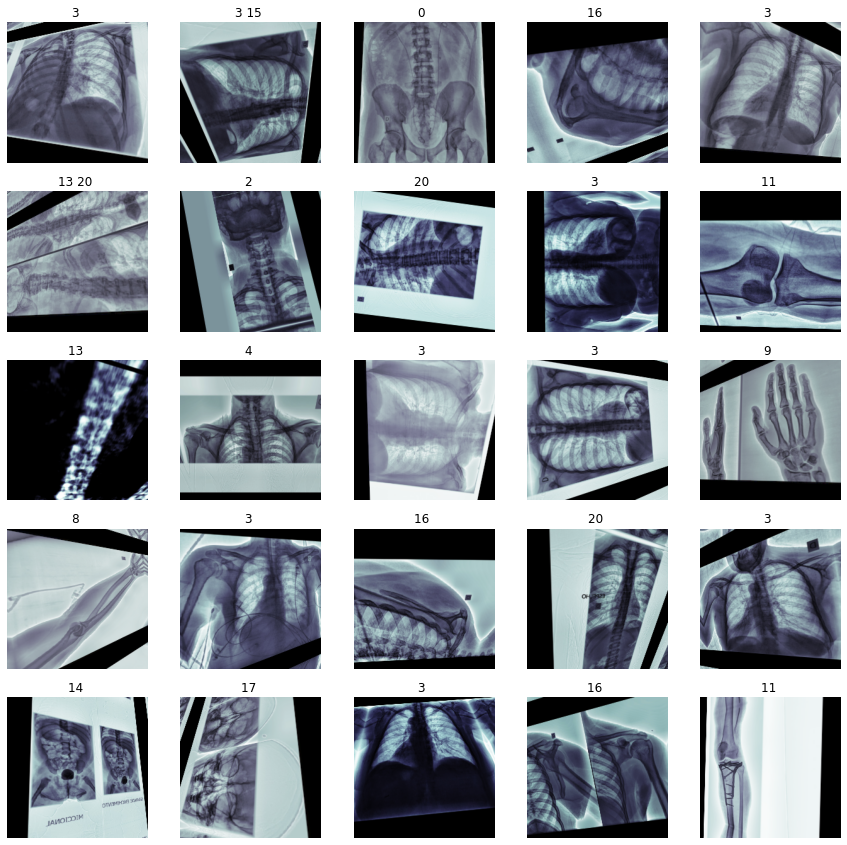

In [47]:
dls.train.show_batch(max_n=25)

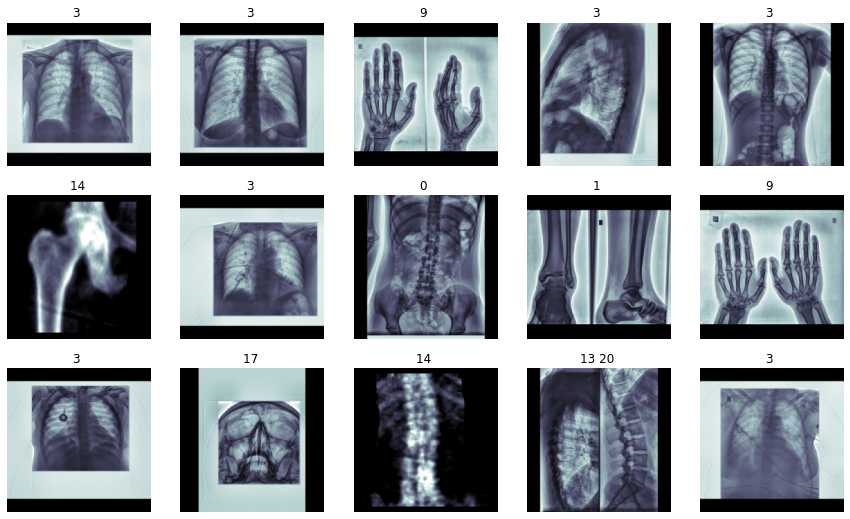

In [48]:
dls.valid.show_batch(max_n=15)

Прогрессивное изменение размера
При прогрессивном изменении размера мы сначала обучаем модель на небольших изображениях, а затем постепенно увеличиваем их размер.

Обучать модели на изображениях меньшего размера гораздо быстрее. Кроме того, при увеличении размера модель видит больше деталей. Следовательно, мы можем обучить модель гораздо быстрее.

Мы начнем со 128x128 и постепенно увеличим размер изображения до 528x528.



In [55]:
f1score = F1Score(average='macro')
metrics = [accuracy, f1score]

In [50]:
dls = get_data(train_df, 128, 64)

In [56]:
learn = vision_learner(dls, resnet152, metrics=metrics).to_fp16()

/usr/local/lib/python3.7/dist-packages/torchvision/models/_utils.py:136: UserWarning: Using 'weights' as positional parameter(s) is deprecated since 0.13 and will be removed in 0.15. Please use keyword parameter(s) instead.
  f"Using {sequence_to_str(tuple(keyword_only_kwargs.keys()), separate_last='and ')} as positional "
/usr/local/lib/python3.7/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and will be removed in 0.15. The current behavior is equivalent to passing `weights=ResNet152_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet152_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


In [57]:
learn.fine_tune(1, 1e-3,wd=0.5)

epoch,train_loss,valid_loss,accuracy,f1_score,time
0,4.257382,1.371779,0.668588,0.234963,00:17


epoch,train_loss,valid_loss,accuracy,f1_score,time
0,2.097266,1.000270,0.743516,0.329728,00:14


In [58]:
del learn

In [59]:
torch.cuda.empty_cache()
gc.collect()

91898

In [ ]:
## Size 256x256


In [60]:
dls = get_data(train_df, 256, 32)

In [61]:
learn = vision_learner(dls, resnet152, metrics=metrics).to_fp16()

/usr/local/lib/python3.7/dist-packages/torchvision/models/_utils.py:136: UserWarning: Using 'weights' as positional parameter(s) is deprecated since 0.13 and will be removed in 0.15. Please use keyword parameter(s) instead.
  f"Using {sequence_to_str(tuple(keyword_only_kwargs.keys()), separate_last='and ')} as positional "
/usr/local/lib/python3.7/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and will be removed in 0.15. The current behavior is equivalent to passing `weights=ResNet152_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet152_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


In [62]:
learn.freeze() 

In [63]:
learn.fine_tune(4, 1e-3, wd=0.5)

epoch,train_loss,valid_loss,accuracy,f1_score,time
0,3.214348,1.063960,0.726225,0.357678,00:22


epoch,train_loss,valid_loss,accuracy,f1_score,time
0,1.471229,0.702820,0.815562,0.468370,00:30
1,1.133265,0.628993,0.841499,0.567674,00:23
2,0.942525,0.573959,0.847262,0.551756,00:24
3,0.756966,0.559268,0.855908,0.597798,00:23


In [64]:
del learn

In [65]:
torch.cuda.empty_cache()
gc.collect()

8507

In [ ]:
## Size 448x448


In [66]:
dls = get_data(train_df, 448, 16)

In [67]:
learn = vision_learner(dls, resnet152, metrics=metrics).to_fp16()

/usr/local/lib/python3.7/dist-packages/torchvision/models/_utils.py:136: UserWarning: Using 'weights' as positional parameter(s) is deprecated since 0.13 and will be removed in 0.15. Please use keyword parameter(s) instead.
  f"Using {sequence_to_str(tuple(keyword_only_kwargs.keys()), separate_last='and ')} as positional "
/usr/local/lib/python3.7/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and will be removed in 0.15. The current behavior is equivalent to passing `weights=ResNet152_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet152_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


In [68]:
learn.unfreeze()

In [69]:
learn.fit_one_cycle(3, slice(1e-5, 1e-4), wd=0.5)

epoch,train_loss,valid_loss,accuracy,f1_score,time
0,3.770743,1.789191,0.582133,0.160536,01:02
1,2.271379,1.067869,0.729107,0.304801,01:00
2,1.662977,0.961183,0.746398,0.354697,01:00


In [70]:
del learn

In [71]:
torch.cuda.empty_cache() 
gc.collect() 

8546

In [ ]:
## Size 528x528


In [72]:
dls = get_data(train_df, 528, 16)

In [73]:
learn = vision_learner(dls, resnet152, metrics=metrics).to_fp16()

/usr/local/lib/python3.7/dist-packages/torchvision/models/_utils.py:136: UserWarning: Using 'weights' as positional parameter(s) is deprecated since 0.13 and will be removed in 0.15. Please use keyword parameter(s) instead.
  f"Using {sequence_to_str(tuple(keyword_only_kwargs.keys()), separate_last='and ')} as positional "
/usr/local/lib/python3.7/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and will be removed in 0.15. The current behavior is equivalent to passing `weights=ResNet152_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet152_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


In [74]:
learn.unfreeze()

In [75]:
learn.fit_one_cycle(3, slice(1e-5, 1e-4), wd=0.5) 

epoch,train_loss,valid_loss,accuracy,f1_score,time
0,3.771423,1.717315,0.625360,0.158548,01:58
1,2.308135,1.148424,0.714697,0.270281,01:58
2,1.787355,0.999820,0.746398,0.343895,01:58


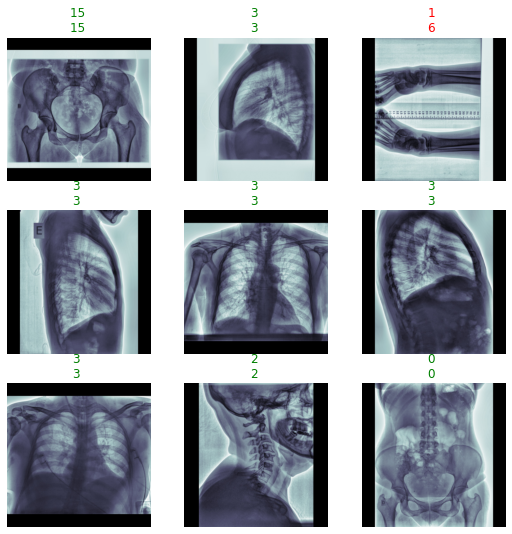

In [76]:
learn.show_results()

In [ ]:
#Predictions to csv

In [ ]:
#!zip -r test.zip /content/drive/MyDrive/xr/xray/test

In [ ]:
#!unzip -j /content/test.zip -d /content/drive/MyDrive/test

In [ ]:
test_df = pd.read_csv ('/content/drive/MyDrive/sample_submission.csv')
# pd.read_csv ('/content/submit.csv')
#pd.read_csv ('/content/drive/MyDrive/xr/xray/sample_submission.csv')
test_path= ('/content/drive/MyDrive/test')

In [ ]:
test_df

,SOPInstanceUID,Target
0,1.2.826.0.1.3680043.8.498.10001001190452685542754353271306894106,0 1 2 3 4 5 6 7 8 9 10 11 12 13 14 15 16 17 18 19 20 21
1,1.2.826.0.1.3680043.8.498.10022667601042710442884728915610557590,0 1 2 3 4 5 6 7 8 9 10 11 12 13 14 15 16 17 18 19 20 21
2,1.2.826.0.1.3680043.8.498.10024395388921105474336784272390605225,0 1 2 3 4 5 6 7 8 9 10 11 12 13 14 15 16 17 18 19 20 21
3,1.2.826.0.1.3680043.8.498.10026689165626095651568657562992631805,0 1 2 3 4 5 6 7 8 9 10 11 12 13 14 15 16 17 18 19 20 21
4,1.2.826.0.1.3680043.8.498.10035936364561920980924160549027696414,0 1 2 3 4 5 6 7 8 9 10 11 12 13 14 15 16 17 18 19 20 21
...,...,...
738,1.2.826.0.1.3680043.8.498.98950979295424909746555980174715994054,0 1 2 3 4 5 6 7 8 9 10 11 12 13 14 15 16 17 18 19 20 21
739,1.2.826.0.1.3680043.8.498.99120415799121180043999929775380253296,0 1 2 3 4 5 6 7 8 9 10 11 12 13 14 15 16 17 18 19 20 21
740,1.2.826.0.1.3680043.8.498.99132008951330408682785705454375383148,0 1 2 3 4 5 6 7 8 9 10 11 12 13 14 15 16 17 18 19 20 21
741,1.2.826.0.1.3680043.8.498.99611256581875030709909119881605604054,0 1 2 3 4 5 6 7 8 9 10 11 12 13 14 15 16 17 18 19 20 21


In [ ]:
tdls = ImageDataLoaders.from_df(test_df, path=test_path, suff='-c.bone.jpg',
   item_tfms=item_tfms, batch_tfms=batch_tfms, shuffle=False)
tst_dl = tdls.test_dl(test_df) 

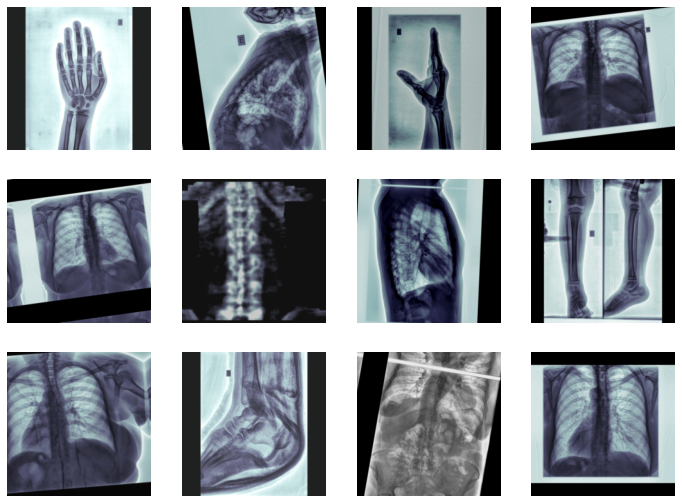

In [ ]:
tst_dl.show_batch(max_n=12)

In [ ]:
%%time
preds = learn.tta(dl=tst_dl, n=64, use_max=False)
#preds = learn.get_preds(dl=tst_dl, n=64, use_max=False)
#preds = learn.get_preds(dl=tst_dl)
#preds = learn.get_preds

CPU times: user 1min 58s, sys: 7.57 s, total: 2min 5s
Wall time: 19min 41s


In [ ]:
#!pip uninstall nbdev.
#!pip install nbdev

In [ ]:
predss = learn.dls.vocab[np.argmax(preds[0], axis=1)]

In [ ]:
test_df['Target'] = predss

In [ ]:
submission_df = test_df[['SOPInstanceUID', 'Target']]

In [ ]:
submission_df.to_csv(f'Goooodboy.csv', header=True, index=False)

In [ ]:
submission_df

,SOPInstanceUID,Target
0,1.2.826.0.1.3680043.8.498.10001001190452685542754353271306894106,9
1,1.2.826.0.1.3680043.8.498.10022667601042710442884728915610557590,3
2,1.2.826.0.1.3680043.8.498.10024395388921105474336784272390605225,21
3,1.2.826.0.1.3680043.8.498.10026689165626095651568657562992631805,3
4,1.2.826.0.1.3680043.8.498.10035936364561920980924160549027696414,3
...,...,...
738,1.2.826.0.1.3680043.8.498.98950979295424909746555980174715994054,3
739,1.2.826.0.1.3680043.8.498.99120415799121180043999929775380253296,3
740,1.2.826.0.1.3680043.8.498.99132008951330408682785705454375383148,3
741,1.2.826.0.1.3680043.8.498.99611256581875030709909119881605604054,21


In [ ]:
test_df.Target.value_counts()

3     338
14     53
0      50
6      46
11     44
21     31
9      27
15     27
13     20
1      20
2      16
16     14
20     13
5      11
7       6
12      6
10      5
17      5
4       5
18      3
19      2
8       1
Name: Target, dtype: int64

AttributeError: 'dict' object has no attribute ..

'When you bring your learner back in make sure to re-define any functions your model wants to use along with it' - нифига, проще заново загрузить
